In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel
from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, remap_labelsets
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

In [5]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [7]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


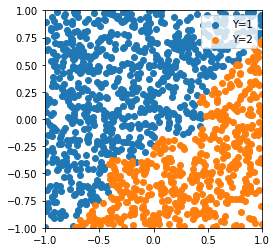

Vizualizing labelset:slice_1:ind from payload_test


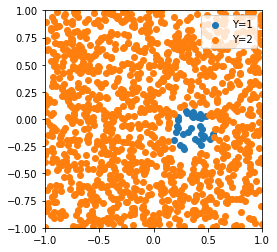

Vizualizing labelset:slice_1:pred from payload_test


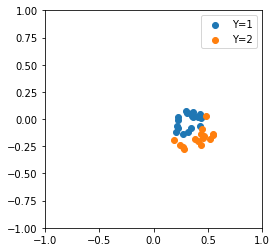

Vizualizing labelset:slice_2:ind from payload_test


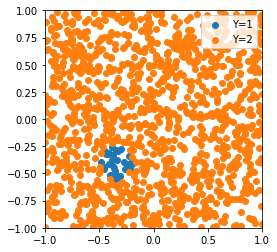

Vizualizing labelset:slice_2:pred from payload_test


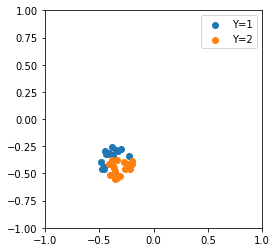

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [10]:
# all models to test to test
model_configs = {
    'soft_param': {
        'slice_funcs': {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn},
        'model_class': SliceModel
    },
    'hard_param': {
        'slice_funcs': {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn},
        'model_class': MetalModel
    },
#     'manual_reweighting': {
#         'slice_funcs': {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn},
#         'model_class': MetalModel        
#     },
    'naive': {
        'slice_funcs': {},
        'model_class': MetalModel   
    },
}

==========Initializing + Training soft_param==========
Creating 7 tasks...
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
BinaryClassificationTask(name=test_task:slice_1:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=0.17, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_1:pred': 'test_task:slice_1:pred', 'labelset:slice_2:ind': 'test_task:slice_2:ind', 'labelset:slice_2:pre

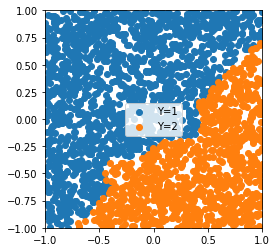

Vizualizing labelset:slice_1:ind from payload_train


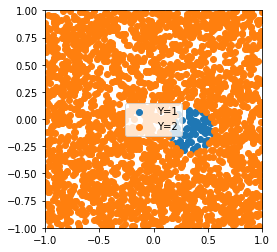

Vizualizing labelset:slice_1:pred from payload_train


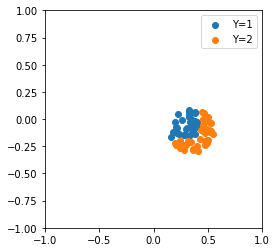

Vizualizing labelset:slice_2:ind from payload_train


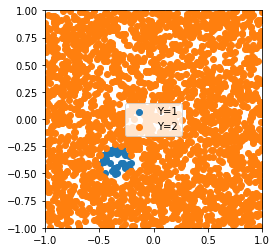

Vizualizing labelset:slice_2:pred from payload_train


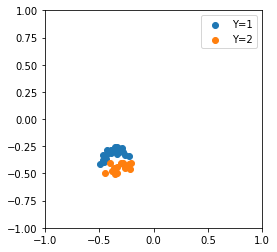

Vizualizing labelset:BASE:ind from payload_train


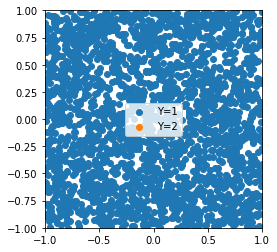

Vizualizing labelset:BASE:pred from payload_train


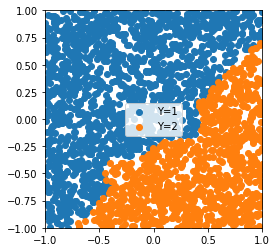

Beginning train loop.
Expecting a total of approximately 2500 examples and 625 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_04_25/22_03_03/config.json


[1.0 epo]: test_task:[payload_train/labelset_gold/loss=1.86e-01, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.90e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.08e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.04e-01, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.07e-01, payload_valid/labelset:slice_2:pred/accuracy=4.29e-01] model:[train/all/loss=5.43e-02, train/all/lr=1.00e-02]



[2.0 epo]: test_task:[payload_train/labelset_gold/loss=8.90e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.85e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.24e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.52e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.55e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=8.88e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=9.63e-02, payload_valid/labelset:slice_2:pred/accuracy=5.71e-01] model:[train/all/loss=2.77e-02, train/all/lr=1.00e-02]



[3.0 epo]: test_task:[payload_train/labelset_gold/loss=9.25e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.76e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.20e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.33e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=8.09e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.79e-02, payload_valid/labelset:slice_2:pred/accuracy=6.43e-01] model:[train/all/loss=2.79e-02, train/all/lr=1.00e-02]



[4.0 epo]: test_task:[payload_train/labelset_gold/loss=9.45e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.72e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.16e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.65e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.69e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.91e-02, payload_valid/labelset:slice_2:pred/accuracy=6.79e-01] model:[train/all/loss=2.80e-02, train/all/lr=1.00e-02]



[5.0 epo]: test_task:[payload_train/labelset_gold/loss=9.47e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.70e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.12e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.44e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.43e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.48e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.08e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.79e-02, train/all/lr=1.00e-02]



[6.0 epo]: test_task:[payload_train/labelset_gold/loss=9.36e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.69e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.08e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.79e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.42e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.19e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.38e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.75e-02, train/all/lr=1.00e-02]



[7.0 epo]: test_task:[payload_train/labelset_gold/loss=9.34e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.67e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.05e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.25e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.07e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.82e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.73e-02, train/all/lr=1.00e-02]



[8.0 epo]: test_task:[payload_train/labelset_gold/loss=9.31e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.65e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.02e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=8.89e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.95e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.46e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.71e-02, train/all/lr=1.00e-02]



[9.0 epo]: test_task:[payload_train/labelset_gold/loss=9.30e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.63e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.00e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.15e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.85e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.11e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.70e-02, train/all/lr=1.00e-02]



[10.0 epo]: test_task:[payload_train/labelset_gold/loss=9.25e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.61e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.84e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.29e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.77e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.79e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.68e-02, train/all/lr=1.00e-02]



[11.0 epo]: test_task:[payload_train/labelset_gold/loss=9.19e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.59e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.16e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.75e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.59e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.66e-02, train/all/lr=1.00e-02]



[12.0 epo]: test_task:[payload_train/labelset_gold/loss=9.16e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.57e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.42e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.29e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.71e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.40e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.65e-02, train/all/lr=1.00e-02]



[13.0 epo]: test_task:[payload_train/labelset_gold/loss=9.10e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.56e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.73e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.71e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.28e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.63e-02, train/all/lr=1.00e-02]



[14.0 epo]: test_task:[payload_train/labelset_gold/loss=9.06e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.31e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.63e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.16e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.61e-02, train/all/lr=1.00e-02]



[15.0 epo]: test_task:[payload_train/labelset_gold/loss=9.02e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.53e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.79e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.01e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.58e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.09e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.60e-02, train/all/lr=1.00e-02]



[16.0 epo]: test_task:[payload_train/labelset_gold/loss=9.00e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.52e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.57e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.78e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.54e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.59e-02, train/all/lr=1.00e-02]



[17.0 epo]: test_task:[payload_train/labelset_gold/loss=8.98e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.51e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.36e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.02e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.00e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.58e-02, train/all/lr=1.00e-02]



[18.0 epo]: test_task:[payload_train/labelset_gold/loss=8.97e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.51e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.82e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.53e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.03e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.57e-02, train/all/lr=1.00e-02]



[19.0 epo]: test_task:[payload_train/labelset_gold/loss=8.93e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.49e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.92e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.44e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.50e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.90e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.55e-02, train/all/lr=1.00e-02]



[20.0 epo]: test_task:[payload_train/labelset_gold/loss=8.91e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.49e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.84e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.50e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.46e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.78e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.55e-02, train/all/lr=1.00e-02]



[21.0 epo]: test_task:[payload_train/labelset_gold/loss=8.91e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.48e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.67e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.85e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.49e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.73e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.54e-02, train/all/lr=1.00e-02]



[22.0 epo]: test_task:[payload_train/labelset_gold/loss=8.90e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.47e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.39e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.47e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.74e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.53e-02, train/all/lr=1.00e-02]



[23.0 epo]: test_task:[payload_train/labelset_gold/loss=8.90e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.46e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.34e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=9.79e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.49e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.66e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.53e-02, train/all/lr=1.00e-02]



[24.0 epo]: test_task:[payload_train/labelset_gold/loss=8.88e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.44e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.23e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.43e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.42e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.61e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.52e-02, train/all/lr=1.00e-02]



[25.0 epo]: test_task:[payload_train/labelset_gold/loss=8.89e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.42e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.57e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.42e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.56e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.51e-02, train/all/lr=1.00e-02]



[26.0 epo]: test_task:[payload_train/labelset_gold/loss=8.90e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.09e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.14e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.40e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.51e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.51e-02, train/all/lr=1.00e-02]



[27.0 epo]: test_task:[payload_train/labelset_gold/loss=8.90e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.69e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.42e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.38e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.47e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.51e-02, train/all/lr=1.00e-02]



[28.0 epo]: test_task:[payload_train/labelset_gold/loss=8.80e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.23e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.64e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.69e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.44e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.10e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.39e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.47e-02, train/all/lr=1.00e-02]



[29.0 epo]: test_task:[payload_train/labelset_gold/loss=8.56e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.09e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.75e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.52e-02, payload_valid/labelset:BASE:pred/accuracy=9.64e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.91e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.34e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.42e-02, train/all/lr=1.00e-02]



[30.0 epo]: test_task:[payload_train/labelset_gold/loss=8.48e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.00e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.49e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.25e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.56e-02, payload_valid/labelset:BASE:pred/accuracy=9.63e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.93e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.39e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.40e-02, train/all/lr=1.00e-02]



[31.0 epo]: test_task:[payload_train/labelset_gold/loss=8.42e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=8.90e-03, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.49e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.93e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.61e-02, payload_valid/labelset:BASE:pred/accuracy=9.64e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.05e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.53e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.38e-02, train/all/lr=1.00e-02]



[32.0 epo]: test_task:[payload_train/labelset_gold/loss=8.00e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=7.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.80e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.57e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.19e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.63e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.01e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.75e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[33.0 epo]: test_task:[payload_train/labelset_gold/loss=7.19e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.32e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.03e-03, payload_valid/labelset:BASE:ind/accuracy=9.99e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.61e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.84e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.13e-02, train/all/lr=1.00e-02]



[34.0 epo]: test_task:[payload_train/labelset_gold/loss=6.85e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.62e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.72e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.99e-03, payload_valid/labelset:BASE:ind/accuracy=9.99e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.56e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.79e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.02e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.04e-02, train/all/lr=1.00e-02]



[35.0 epo]: test_task:[payload_train/labelset_gold/loss=6.63e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.14e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.82e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.51e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.65e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.04e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.97e-02, train/all/lr=1.00e-02]



[36.0 epo]: test_task:[payload_train/labelset_gold/loss=6.45e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.97e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.71e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.48e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.54e-02, payload_valid/labelset:slice_1:pred/accuracy=1.00e+00] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.92e-02, train/all/lr=1.00e-02]



[37.0 epo]: test_task:[payload_train/labelset_gold/loss=6.35e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.64e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.53e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.44e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.31e-02, payload_valid/labelset:slice_1:pred/accuracy=1.00e+00] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.89e-02, train/all/lr=1.00e-02]



[38.0 epo]: test_task:[payload_train/labelset_gold/loss=6.26e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.45e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.75e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.41e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.42e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.05e-02, payload_valid/labelset:slice_1:pred/accuracy=1.00e+00] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.85e-02, train/all/lr=1.00e-02]



[39.0 epo]: test_task:[payload_train/labelset_gold/loss=6.13e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.38e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.36e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.80e-02, payload_valid/labelset:slice_1:pred/accuracy=1.00e+00] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.02e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.82e-02, train/all/lr=1.00e-02]



[40.0 epo]: test_task:[payload_train/labelset_gold/loss=6.01e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.31e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.67e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.31e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.52e-02, payload_valid/labelset:slice_1:pred/accuracy=1.00e+00] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.99e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.79e-02, train/all/lr=1.00e-02]



[41.0 epo]: test_task:[payload_train/labelset_gold/loss=6.02e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.26e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.57e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.20e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.39e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.27e-02, payload_valid/labelset:slice_1:pred/accuracy=9.76e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.78e-02, train/all/lr=1.00e-02]



[42.0 epo]: test_task:[payload_train/labelset_gold/loss=5.95e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.17e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.53e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.15e-03, payload_valid/labelset:BASE:ind/accuracy=9.99e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.07e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.96e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.76e-02, train/all/lr=1.00e-02]



[43.0 epo]: test_task:[payload_train/labelset_gold/loss=5.93e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.03e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.50e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.05e-03, payload_valid/labelset:BASE:ind/accuracy=9.99e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.83e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.75e-02, train/all/lr=1.00e-02]



[44.0 epo]: test_task:[payload_train/labelset_gold/loss=5.92e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.93e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.46e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=9.76e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.64e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.79e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.74e-02, train/all/lr=1.00e-02]



[45.0 epo]: test_task:[payload_train/labelset_gold/loss=5.92e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.84e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=9.10e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.49e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.78e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.73e-02, train/all/lr=1.00e-02]



[46.0 epo]: test_task:[payload_train/labelset_gold/loss=5.93e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.74e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.40e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=8.36e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.33e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.68e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.73e-02, train/all/lr=1.00e-02]



[47.0 epo]: test_task:[payload_train/labelset_gold/loss=5.91e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.33e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=8.23e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.26e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.49e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.72e-02, train/all/lr=1.00e-02]



[48.0 epo]: test_task:[payload_train/labelset_gold/loss=5.89e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.30e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.92e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.14e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.50e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.71e-02, train/all/lr=1.00e-02]



[49.0 epo]: test_task:[payload_train/labelset_gold/loss=5.75e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.55e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.24e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.13e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.02e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.39e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.67e-02, train/all/lr=1.00e-02]



[50.0 epo]: test_task:[payload_train/labelset_gold/loss=5.70e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.46e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.01e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.40e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.66e-02, train/all/lr=1.00e-02]



[51.0 epo]: test_task:[payload_train/labelset_gold/loss=5.69e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.41e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.28e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.62e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.84e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.49e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.65e-02, train/all/lr=1.00e-02]



[52.0 epo]: test_task:[payload_train/labelset_gold/loss=5.50e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.43e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.02e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.79e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.40e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.61e-02, train/all/lr=1.00e-02]



[53.0 epo]: test_task:[payload_train/labelset_gold/loss=5.52e-02, payload_valid/labelset_gold/accuracy=9.77e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.43e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.89e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.69e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.43e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.62e-02, train/all/lr=1.00e-02]



[54.0 epo]: test_task:[payload_train/labelset_gold/loss=5.53e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.44e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.28e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.64e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.44e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.62e-02, train/all/lr=1.00e-02]



[55.0 epo]: test_task:[payload_train/labelset_gold/loss=5.56e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.36e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.05e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.54e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.43e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.62e-02, train/all/lr=1.00e-02]



[56.0 epo]: test_task:[payload_train/labelset_gold/loss=5.61e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.31e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.50e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.40e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.63e-02, train/all/lr=1.00e-02]



[57.0 epo]: test_task:[payload_train/labelset_gold/loss=5.62e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.21e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.24e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.41e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.34e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.63e-02, train/all/lr=1.00e-02]



[58.0 epo]: test_task:[payload_train/labelset_gold/loss=5.61e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.19e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.86e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.38e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.25e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.62e-02, train/all/lr=1.00e-02]



[59.0 epo]: test_task:[payload_train/labelset_gold/loss=5.54e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.16e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.88e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.38e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.23e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.61e-02, train/all/lr=1.00e-02]



[60.0 epo]: test_task:[payload_train/labelset_gold/loss=5.35e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.22e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.22e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.42e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.21e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.57e-02, train/all/lr=1.00e-02]



[61.0 epo]: test_task:[payload_train/labelset_gold/loss=5.22e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.14e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.19e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.40e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.22e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[62.0 epo]: test_task:[payload_train/labelset_gold/loss=5.23e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.07e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.96e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.10e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[63.0 epo]: test_task:[payload_train/labelset_gold/loss=5.06e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.11e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.34e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.42e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.10e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.51e-02, train/all/lr=1.00e-02]



[64.0 epo]: test_task:[payload_train/labelset_gold/loss=4.96e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.03e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.10e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.43e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.08e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.49e-02, train/all/lr=1.00e-02]



[65.0 epo]: test_task:[payload_train/labelset_gold/loss=4.93e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.95e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.24e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.48e-02, train/all/lr=1.00e-02]



[66.0 epo]: test_task:[payload_train/labelset_gold/loss=4.90e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.91e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.11e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.36e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.03e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.47e-02, train/all/lr=1.00e-02]



[67.0 epo]: test_task:[payload_train/labelset_gold/loss=4.85e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.89e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.03e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.02e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.35e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.00e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.46e-02, train/all/lr=1.00e-02]



[68.0 epo]: test_task:[payload_train/labelset_gold/loss=4.74e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.00e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.02e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.37e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.27e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.88e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.44e-02, train/all/lr=1.00e-02]



[69.0 epo]: test_task:[payload_train/labelset_gold/loss=4.68e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.52e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.24e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.91e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.43e-02, train/all/lr=1.00e-02]



[70.0 epo]: test_task:[payload_train/labelset_gold/loss=4.67e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.92e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.97e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.32e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.22e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.87e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.42e-02, train/all/lr=1.00e-02]



[71.0 epo]: test_task:[payload_train/labelset_gold/loss=4.56e-02, payload_valid/labelset_gold/accuracy=9.78e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.96e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.38e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.21e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.76e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.40e-02, train/all/lr=1.00e-02]



[72.0 epo]: test_task:[payload_train/labelset_gold/loss=4.65e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.87e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.98e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.18e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.25e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.82e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.42e-02, train/all/lr=1.00e-02]



[73.0 epo]: test_task:[payload_train/labelset_gold/loss=4.60e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.82e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.20e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.25e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.76e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.41e-02, train/all/lr=1.00e-02]



[74.0 epo]: test_task:[payload_train/labelset_gold/loss=4.63e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.70e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.92e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.01e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.25e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.82e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.41e-02, train/all/lr=1.00e-02]



[75.0 epo]: test_task:[payload_train/labelset_gold/loss=4.51e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.84e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.12e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.26e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.70e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.38e-02, train/all/lr=1.00e-02]



[76.0 epo]: test_task:[payload_train/labelset_gold/loss=4.46e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.68e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.81e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.86e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.23e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.69e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.37e-02, train/all/lr=1.00e-02]



[77.0 epo]: test_task:[payload_train/labelset_gold/loss=4.50e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.71e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.62e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.27e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.67e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.38e-02, train/all/lr=1.00e-02]



[78.0 epo]: test_task:[payload_train/labelset_gold/loss=4.47e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.69e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.76e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.58e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.23e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.63e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.37e-02, train/all/lr=1.00e-02]



[79.0 epo]: test_task:[payload_train/labelset_gold/loss=4.47e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.63e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.74e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.50e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.05e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.60e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.36e-02, train/all/lr=1.00e-02]



[80.0 epo]: test_task:[payload_train/labelset_gold/loss=4.55e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.60e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.30e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.34e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.66e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.38e-02, train/all/lr=1.00e-02]



[81.0 epo]: test_task:[payload_train/labelset_gold/loss=4.55e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.68e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.57e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=2.14e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.53e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.38e-02, train/all/lr=1.00e-02]



[82.0 epo]: test_task:[payload_train/labelset_gold/loss=4.80e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.98e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.53e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.43e-02, train/all/lr=1.00e-02]



[83.0 epo]: test_task:[payload_train/labelset_gold/loss=4.88e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.66e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.66e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.91e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.51e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.45e-02, train/all/lr=1.00e-02]



[84.0 epo]: test_task:[payload_train/labelset_gold/loss=4.89e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.57e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.83e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.49e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.45e-02, train/all/lr=1.00e-02]



[85.0 epo]: test_task:[payload_train/labelset_gold/loss=4.88e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.57e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.71e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.49e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.44e-02, train/all/lr=1.00e-02]



[86.0 epo]: test_task:[payload_train/labelset_gold/loss=4.93e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.67e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.68e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.49e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.72e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.48e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.45e-02, train/all/lr=1.00e-02]



[87.0 epo]: test_task:[payload_train/labelset_gold/loss=5.39e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.66e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.47e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[88.0 epo]: test_task:[payload_train/labelset_gold/loss=5.35e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.52e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.73e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.45e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[89.0 epo]: test_task:[payload_train/labelset_gold/loss=5.37e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.58e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.56e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.75e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.41e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[90.0 epo]: test_task:[payload_train/labelset_gold/loss=5.20e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.57e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.67e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.56e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.38e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.51e-02, train/all/lr=1.00e-02]



[91.0 epo]: test_task:[payload_train/labelset_gold/loss=5.37e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.55e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.64e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.68e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.82e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.36e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[92.0 epo]: test_task:[payload_train/labelset_gold/loss=5.26e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.54e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.47e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.35e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.51e-02, train/all/lr=1.00e-02]



[93.0 epo]: test_task:[payload_train/labelset_gold/loss=4.41e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.40e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.58e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.20e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.77e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.45e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.34e-02, train/all/lr=1.00e-02]



[94.0 epo]: test_task:[payload_train/labelset_gold/loss=5.06e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.51e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.59e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.24e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.23e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.54e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.32e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.47e-02, train/all/lr=1.00e-02]



[95.0 epo]: test_task:[payload_train/labelset_gold/loss=5.28e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.49e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.59e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.11e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.31e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.52e-02, train/all/lr=1.00e-02]



[96.0 epo]: test_task:[payload_train/labelset_gold/loss=5.19e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.56e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.19e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.64e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.28e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.50e-02, train/all/lr=1.00e-02]



[97.0 epo]: test_task:[payload_train/labelset_gold/loss=5.17e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.57e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.23e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.74e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.43e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.49e-02, train/all/lr=1.00e-02]



[98.0 epo]: test_task:[payload_train/labelset_gold/loss=5.34e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.39e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.55e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.99e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.67e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.31e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.53e-02, train/all/lr=1.00e-02]



[99.0 epo]: test_task:[payload_train/labelset_gold/loss=5.39e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.39e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.51e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.94e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.25e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.53e-02, train/all/lr=1.00e-02]



[100.0 epo]: test_task:[payload_train/labelset_gold/loss=5.26e-02, payload_valid/labelset_gold/accuracy=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.40e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.53e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.09e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.58e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.42e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.51e-02, train/all/lr=1.00e-02]



[101.0 epo]: test_task:[payload_train/labelset_gold/loss=5.39e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.34e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.52e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.76e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.59e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.28e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.53e-02, train/all/lr=1.00e-02]



[102.0 epo]: test_task:[payload_train/labelset_gold/loss=5.40e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.35e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.46e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.73e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.20e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.53e-02, train/all/lr=1.00e-02]



[103.0 epo]: test_task:[payload_train/labelset_gold/loss=5.19e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.42e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.50e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.08e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.51e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.33e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.50e-02, train/all/lr=1.00e-02]



[104.0 epo]: test_task:[payload_train/labelset_gold/loss=5.41e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.33e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.47e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.80e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.61e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.26e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[105.0 epo]: test_task:[payload_train/labelset_gold/loss=5.44e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.33e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.64e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.21e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[106.0 epo]: test_task:[payload_train/labelset_gold/loss=5.41e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.35e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.41e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.60e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.64e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.17e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[107.0 epo]: test_task:[payload_train/labelset_gold/loss=5.14e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.37e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.46e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.86e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.56e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.37e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.48e-02, train/all/lr=1.00e-02]



[108.0 epo]: test_task:[payload_train/labelset_gold/loss=4.55e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.22e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.41e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.56e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.59e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.29e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.36e-02, train/all/lr=1.00e-02]



[109.0 epo]: test_task:[payload_train/labelset_gold/loss=4.82e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.32e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.39e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.56e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.53e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.12e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.42e-02, train/all/lr=1.00e-02]



[110.0 epo]: test_task:[payload_train/labelset_gold/loss=5.14e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.37e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.54e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.56e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.34e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.48e-02, train/all/lr=1.00e-02]



[111.0 epo]: test_task:[payload_train/labelset_gold/loss=5.40e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.32e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.38e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.78e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.56e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.10e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.53e-02, train/all/lr=1.00e-02]



[112.0 epo]: test_task:[payload_train/labelset_gold/loss=4.46e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.22e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.38e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.42e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.58e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.16e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.34e-02, train/all/lr=1.00e-02]



[113.0 epo]: test_task:[payload_train/labelset_gold/loss=5.05e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.34e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.38e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.95e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.33e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.10e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.46e-02, train/all/lr=1.00e-02]



[114.0 epo]: test_task:[payload_train/labelset_gold/loss=5.43e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.33e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.36e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.52e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.56e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.04e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[115.0 epo]: test_task:[payload_train/labelset_gold/loss=5.33e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.35e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.34e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.48e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.02e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.52e-02, train/all/lr=1.00e-02]



[116.0 epo]: test_task:[payload_train/labelset_gold/loss=5.12e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.29e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.39e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.46e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.24e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.48e-02, train/all/lr=1.00e-02]



[117.0 epo]: test_task:[payload_train/labelset_gold/loss=5.52e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.25e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.33e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.44e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.56e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.02e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.55e-02, train/all/lr=1.00e-02]



[118.0 epo]: test_task:[payload_train/labelset_gold/loss=5.43e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.31e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.32e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.41e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.52e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.99e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.54e-02, train/all/lr=1.00e-02]



[119.0 epo]: test_task:[payload_train/labelset_gold/loss=5.04e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.31e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.35e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.25e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.11e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.46e-02, train/all/lr=1.00e-02]



[120.0 epo]: test_task:[payload_train/labelset_gold/loss=5.58e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.24e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.33e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.18e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.56e-02, train/all/lr=1.00e-02]



[121.0 epo]: test_task:[payload_train/labelset_gold/loss=5.56e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.21e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.32e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.11e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.54e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.03e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.56e-02, train/all/lr=1.00e-02]



[122.0 epo]: test_task:[payload_train/labelset_gold/loss=5.52e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.22e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.32e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.73e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.30e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.30e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.55e-02, train/all/lr=1.00e-02]



[123.0 epo]: test_task:[payload_train/labelset_gold/loss=5.60e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.22e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.28e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.10e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.60e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.00e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.57e-02, train/all/lr=1.00e-02]



[124.0 epo]: test_task:[payload_train/labelset_gold/loss=5.83e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.12e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.30e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.06e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.37e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.28e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.61e-02, train/all/lr=1.00e-02]



[125.0 epo]: test_task:[payload_train/labelset_gold/loss=5.60e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.15e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.28e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.03e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.92e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.56e-02, train/all/lr=1.00e-02]



[126.0 epo]: test_task:[payload_train/labelset_gold/loss=5.91e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.13e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.28e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.22e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.46e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.12e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.63e-02, train/all/lr=1.00e-02]



[127.0 epo]: test_task:[payload_train/labelset_gold/loss=5.56e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.77e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.52e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.12e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.55e-02, train/all/lr=1.00e-02]



[128.0 epo]: test_task:[payload_train/labelset_gold/loss=5.66e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.89e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.28e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.38e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.67e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.88e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.57e-02, train/all/lr=1.00e-02]



[129.0 epo]: test_task:[payload_train/labelset_gold/loss=6.25e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.02e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.32e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.71e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.58e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.98e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.69e-02, train/all/lr=1.00e-02]



[130.0 epo]: test_task:[payload_train/labelset_gold/loss=5.62e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.18e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.30e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.60e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.68e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.57e-02, train/all/lr=1.00e-02]



[131.0 epo]: test_task:[payload_train/labelset_gold/loss=6.16e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.16e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.28e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.04e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.55e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.84e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.68e-02, train/all/lr=1.00e-02]



[132.0 epo]: test_task:[payload_train/labelset_gold/loss=5.76e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.28e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.13e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.70e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.72e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.60e-02, train/all/lr=1.00e-02]



[133.0 epo]: test_task:[payload_train/labelset_gold/loss=5.68e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.21e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.96e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.60e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.66e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02]



[134.0 epo]: test_task:[payload_train/labelset_gold/loss=5.64e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.21e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.86e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.64e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.57e-02, train/all/lr=1.00e-02]



[135.0 epo]: test_task:[payload_train/labelset_gold/loss=6.14e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.14e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.90e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.50e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.88e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.67e-02, train/all/lr=1.00e-02]



[136.0 epo]: test_task:[payload_train/labelset_gold/loss=6.16e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.10e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.48e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.67e-02, train/all/lr=1.00e-02]



[137.0 epo]: test_task:[payload_train/labelset_gold/loss=5.69e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.15e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.80e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.60e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.67e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02]



[138.0 epo]: test_task:[payload_train/labelset_gold/loss=5.70e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.15e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.24e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.61e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.64e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02]



[139.0 epo]: test_task:[payload_train/labelset_gold/loss=6.18e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.05e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.50e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.98e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.68e-02, train/all/lr=1.00e-02]



[140.0 epo]: test_task:[payload_train/labelset_gold/loss=5.72e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.09e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.67e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.66e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02]



[141.0 epo]: test_task:[payload_train/labelset_gold/loss=5.70e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.10e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.57e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.66e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02]



[142.0 epo]: test_task:[payload_train/labelset_gold/loss=5.44e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.84e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.15e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.58e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.26e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.53e-02, train/all/lr=1.00e-02]



[143.0 epo]: test_task:[payload_train/labelset_gold/loss=5.83e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.79e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.16e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.06e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.69e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.69e-02, payload_valid/labelset:slice_2:pred/accuracy=7.14e-01] model:[train/all/loss=1.60e-02, train/all/lr=1.00e-02]



[144.0 epo]: test_task:[payload_train/labelset_gold/loss=5.71e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.76e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.55e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.51e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02]



[145.0 epo]: test_task:[payload_train/labelset_gold/loss=5.71e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.09e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.50e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.63e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.58e-02, train/all/lr=1.00e-02]



[146.0 epo]: test_task:[payload_train/labelset_gold/loss=5.74e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.47e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.63e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.60e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.59e-02, train/all/lr=1.00e-02]



[147.0 epo]: test_task:[payload_train/labelset_gold/loss=5.78e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.89e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.25e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.18e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.59e-02, train/all/lr=1.00e-02]



[148.0 epo]: test_task:[payload_train/labelset_gold/loss=5.84e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.78e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.05e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.67e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.63e-02, payload_valid/labelset:slice_2:pred/accuracy=7.14e-01] model:[train/all/loss=1.60e-02, train/all/lr=1.00e-02]



[149.0 epo]: test_task:[payload_train/labelset_gold/loss=5.73e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.54e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.45e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.59e-02, train/all/lr=1.00e-02]



[150.0 epo]: test_task:[payload_train/labelset_gold/loss=6.27e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.04e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.15e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.60e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.59e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.80e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.69e-02, train/all/lr=1.00e-02]



[151.0 epo]: test_task:[payload_train/labelset_gold/loss=5.79e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.96e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.46e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.66e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.55e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.60e-02, train/all/lr=1.00e-02]



[152.0 epo]: test_task:[payload_train/labelset_gold/loss=5.37e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.16e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.22e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.73e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.51e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.51e-02, train/all/lr=1.00e-02]



[153.0 epo]: test_task:[payload_train/labelset_gold/loss=6.22e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.00e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.37e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.45e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.77e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.68e-02, train/all/lr=1.00e-02]



[154.0 epo]: test_task:[payload_train/labelset_gold/loss=5.75e-02, payload_valid/labelset_gold/accuracy=9.79e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.00e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.50e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.64e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.52e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.59e-02, train/all/lr=1.00e-02]



[155.0 epo]: test_task:[payload_train/labelset_gold/loss=5.26e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.01e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.15e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.23e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.65e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.49e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.49e-02, train/all/lr=1.00e-02]



[156.0 epo]: test_task:[payload_train/labelset_gold/loss=6.21e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.47e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.73e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.68e-02, train/all/lr=1.00e-02]



[157.0 epo]: test_task:[payload_train/labelset_gold/loss=5.44e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.09e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.09e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.80e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.12e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.52e-02, train/all/lr=1.00e-02]



[158.0 epo]: test_task:[payload_train/labelset_gold/loss=6.55e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.80e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.11e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.63e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.02e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.75e-02, train/all/lr=1.00e-02]



[159.0 epo]: test_task:[payload_train/labelset_gold/loss=6.54e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.84e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.16e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.67e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.75e-02, train/all/lr=1.00e-02]



[160.0 epo]: test_task:[payload_train/labelset_gold/loss=5.45e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.85e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.57e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.74e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.12e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.53e-02, train/all/lr=1.00e-02]



[161.0 epo]: test_task:[payload_train/labelset_gold/loss=6.26e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.10e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.52e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.50e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.69e-02, train/all/lr=1.00e-02]



[162.0 epo]: test_task:[payload_train/labelset_gold/loss=5.78e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.07e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.09e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.56e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.30e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.59e-02, train/all/lr=1.00e-02]



[163.0 epo]: test_task:[payload_train/labelset_gold/loss=5.85e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.08e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.32e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.26e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.63e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.61e-02, train/all/lr=1.00e-02]



[164.0 epo]: test_task:[payload_train/labelset_gold/loss=6.45e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.86e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.24e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.53e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.93e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.73e-02, train/all/lr=1.00e-02]



[165.0 epo]: test_task:[payload_train/labelset_gold/loss=6.46e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.90e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.77e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.46e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.73e-02, train/all/lr=1.00e-02]



[166.0 epo]: test_task:[payload_train/labelset_gold/loss=5.74e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.10e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.10e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.80e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.45e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.26e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.59e-02, train/all/lr=1.00e-02]



[167.0 epo]: test_task:[payload_train/labelset_gold/loss=5.76e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.10e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.10e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.50e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.30e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.59e-02, train/all/lr=1.00e-02]



[168.0 epo]: test_task:[payload_train/labelset_gold/loss=6.26e-02, payload_valid/labelset_gold/accuracy=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.03e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.09e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.54e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.25e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.50e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.37e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.69e-02, train/all/lr=1.00e-02]



[169.0 epo]: test_task:[payload_train/labelset_gold/loss=5.68e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.96e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.12e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.06e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.27e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.90e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=1.57e-02, train/all/lr=1.00e-02]



[170.0 epo]: test_task:[payload_train/labelset_gold/loss=5.78e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.69e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.04e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.00e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.63e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.37e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.59e-02, train/all/lr=1.00e-02]



[171.0 epo]: test_task:[payload_train/labelset_gold/loss=6.38e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.92e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.10e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.52e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.46e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.44e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.72e-02, train/all/lr=1.00e-02]



[172.0 epo]: test_task:[payload_train/labelset_gold/loss=6.42e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.88e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.10e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.58e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.58e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.44e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.72e-02, train/all/lr=1.00e-02]



[173.0 epo]: test_task:[payload_train/labelset_gold/loss=6.55e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.80e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.08e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.45e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.72e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.75e-02, train/all/lr=1.00e-02]



[174.0 epo]: test_task:[payload_train/labelset_gold/loss=6.63e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.65e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.76e-02, train/all/lr=1.00e-02]



[175.0 epo]: test_task:[payload_train/labelset_gold/loss=6.56e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.82e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.06e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.69e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.72e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.33e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.75e-02, train/all/lr=1.00e-02]



[176.0 epo]: test_task:[payload_train/labelset_gold/loss=6.45e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.91e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.08e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.76e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.66e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.32e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.73e-02, train/all/lr=1.00e-02]



[177.0 epo]: test_task:[payload_train/labelset_gold/loss=6.43e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.94e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.68e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.61e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.33e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.73e-02, train/all/lr=1.00e-02]



[178.0 epo]: test_task:[payload_train/labelset_gold/loss=6.46e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.87e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.54e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.64e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.38e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.73e-02, train/all/lr=1.00e-02]



[179.0 epo]: test_task:[payload_train/labelset_gold/loss=6.60e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.04e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.43e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.71e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.68e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.76e-02, train/all/lr=1.00e-02]



[180.0 epo]: test_task:[payload_train/labelset_gold/loss=6.67e-02, payload_valid/labelset_gold/accuracy=9.83e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.72e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.04e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.67e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.69e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.60e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.77e-02, train/all/lr=1.00e-02]



[181.0 epo]: test_task:[payload_train/labelset_gold/loss=6.58e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.80e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.04e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.73e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.28e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.76e-02, train/all/lr=1.00e-02]



[182.0 epo]: test_task:[payload_train/labelset_gold/loss=6.50e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.89e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.03e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.71e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.31e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.74e-02, train/all/lr=1.00e-02]



[183.0 epo]: test_task:[payload_train/labelset_gold/loss=6.47e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.91e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.81e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.28e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.73e-02, train/all/lr=1.00e-02]



[184.0 epo]: test_task:[payload_train/labelset_gold/loss=6.50e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.86e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.02e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.28e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.65e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.36e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.74e-02, train/all/lr=1.00e-02]



[185.0 epo]: test_task:[payload_train/labelset_gold/loss=6.61e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.49e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.71e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.64e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.76e-02, train/all/lr=1.00e-02]



[186.0 epo]: test_task:[payload_train/labelset_gold/loss=6.70e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.72e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.66e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.56e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.78e-02, train/all/lr=1.00e-02]



[187.0 epo]: test_task:[payload_train/labelset_gold/loss=6.61e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.79e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.02e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.70e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.66e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.25e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.76e-02, train/all/lr=1.00e-02]



[188.0 epo]: test_task:[payload_train/labelset_gold/loss=6.54e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.85e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.70e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.33e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.75e-02, train/all/lr=1.00e-02]



[189.0 epo]: test_task:[payload_train/labelset_gold/loss=6.51e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.86e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.63e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.29e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.74e-02, train/all/lr=1.00e-02]



[190.0 epo]: test_task:[payload_train/labelset_gold/loss=6.52e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.84e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.65e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.31e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.74e-02, train/all/lr=1.00e-02]



[191.0 epo]: test_task:[payload_train/labelset_gold/loss=6.63e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.70e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.58e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.76e-02, train/all/lr=1.00e-02]



[192.0 epo]: test_task:[payload_train/labelset_gold/loss=6.72e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.71e-03, payload_valid/labelset:slice_1:ind/accuracy=9.95e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.98e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.69e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.69e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.51e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.78e-02, train/all/lr=1.00e-02]



[193.0 epo]: test_task:[payload_train/labelset_gold/loss=6.64e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.78e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.65e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.20e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.77e-02, train/all/lr=1.00e-02]



[194.0 epo]: test_task:[payload_train/labelset_gold/loss=5.97e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.69e-03, payload_valid/labelset:slice_1:ind/accuracy=9.96e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.96e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.11e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.80e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.57e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.63e-02, train/all/lr=1.00e-02]



[195.0 epo]: test_task:[payload_train/labelset_gold/loss=6.15e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.97e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.96e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.85e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.57e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.66e-02, train/all/lr=1.00e-02]



[196.0 epo]: test_task:[payload_train/labelset_gold/loss=6.23e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.85e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.97e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.56e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.57e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=7.33e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.68e-02, train/all/lr=1.00e-02]



[197.0 epo]: test_task:[payload_train/labelset_gold/loss=6.11e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.83e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.98e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.22e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.70e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.25e-02, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.66e-02, train/all/lr=1.00e-02]



[198.0 epo]: test_task:[payload_train/labelset_gold/loss=6.00e-02, payload_valid/labelset_gold/accuracy=9.81e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.97e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.94e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.92e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.63e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.59e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.64e-02, train/all/lr=1.00e-02]



[199.0 epo]: test_task:[payload_train/labelset_gold/loss=6.26e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.88e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.96e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.59e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.85e-03, payload_valid/labelset:slice_2:pred/accuracy=7.50e-01] model:[train/all/loss=1.69e-02, train/all/lr=1.00e-02]



[200.0 epo]: test_task:[payload_train/labelset_gold/loss=6.05e-02, payload_valid/labelset_gold/accuracy=9.82e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.83e-03, payload_valid/labelset:slice_1:ind/accuracy=9.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.96e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.16e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.76e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.12e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=1.65e-02, train/all/lr=1.00e-02]

Finished training
{'test_task/payload_test/labelset_gold/accuracy': 0.9792,
 

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


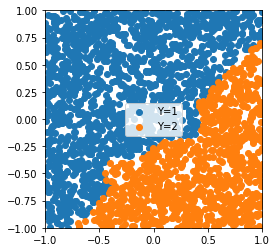

Vizualizing labelset:slice_1:ind from payload_train


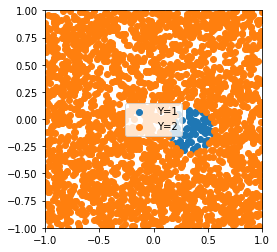

Vizualizing labelset:slice_1:pred from payload_train


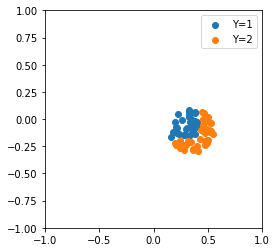

Vizualizing labelset:slice_2:ind from payload_train


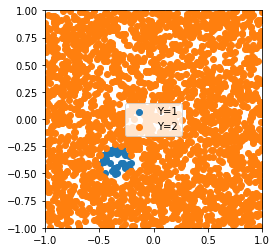

Vizualizing labelset:slice_2:pred from payload_train


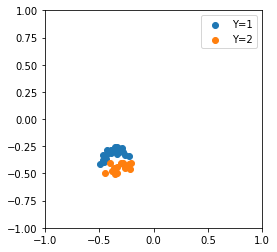

Vizualizing labelset:BASE:ind from payload_train


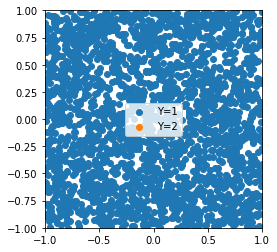

Vizualizing labelset:BASE:pred from payload_train


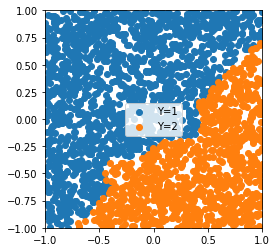

Beginning train loop.
Expecting a total of approximately 2500 examples and 625 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_04_25/22_18_18/config.json


[1.0 epo]: test_task:[payload_train/labelset_gold/loss=2.29e-01, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=2.86e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.03e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.02e-02, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=1.14e-01, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.13e-01, payload_valid/labelset:slice_2:pred/accuracy=4.29e-01] model:[train/all/loss=6.56e-02, train/all/lr=1.00e-02]



[2.0 epo]: test_task:[payload_train/labelset_gold/loss=9.17e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.95e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.17e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.71e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.53e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=9.56e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=9.78e-02, payload_valid/labelset:slice_2:pred/accuracy=7.14e-01] model:[train/all/loss=2.83e-02, train/all/lr=1.00e-02]



[3.0 epo]: test_task:[payload_train/labelset_gold/loss=8.63e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.83e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.16e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.08e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.44e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=8.33e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=8.17e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.66e-02, train/all/lr=1.00e-02]



[4.0 epo]: test_task:[payload_train/labelset_gold/loss=8.56e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.78e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.14e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.16e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.43e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.60e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.63e-02, train/all/lr=1.00e-02]



[5.0 epo]: test_task:[payload_train/labelset_gold/loss=8.59e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.76e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.14e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.74e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.43e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.15e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=6.01e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.62e-02, train/all/lr=1.00e-02]



[6.0 epo]: test_task:[payload_train/labelset_gold/loss=8.63e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.74e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.13e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.95e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.44e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.88e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=5.25e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.62e-02, train/all/lr=1.00e-02]



[7.0 epo]: test_task:[payload_train/labelset_gold/loss=8.67e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.72e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.12e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.40e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.44e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.71e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.70e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.62e-02, train/all/lr=1.00e-02]



[8.0 epo]: test_task:[payload_train/labelset_gold/loss=8.70e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.70e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.12e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.03e-05, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.62e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=4.31e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.62e-02, train/all/lr=1.00e-02]



[9.0 epo]: test_task:[payload_train/labelset_gold/loss=8.72e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.68e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.12e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.71e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.58e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.88e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.62e-02, train/all/lr=1.00e-02]



[10.0 epo]: test_task:[payload_train/labelset_gold/loss=8.74e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.67e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.11e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.83e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.53e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.65e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.62e-02, train/all/lr=1.00e-02]



[11.0 epo]: test_task:[payload_train/labelset_gold/loss=8.75e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.66e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.10e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.42e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.51e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.40e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.62e-02, train/all/lr=1.00e-02]



[12.0 epo]: test_task:[payload_train/labelset_gold/loss=8.75e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.64e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.09e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.48e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.55e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.21e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.62e-02, train/all/lr=1.00e-02]



[13.0 epo]: test_task:[payload_train/labelset_gold/loss=8.75e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.62e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.08e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.73e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.46e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.58e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.61e-02, train/all/lr=1.00e-02]



[14.0 epo]: test_task:[payload_train/labelset_gold/loss=8.72e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.60e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.07e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.24e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.67e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.92e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.60e-02, train/all/lr=1.00e-02]



[15.0 epo]: test_task:[payload_train/labelset_gold/loss=8.67e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.57e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.06e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.98e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.44e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.96e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.80e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.58e-02, train/all/lr=1.00e-02]



[16.0 epo]: test_task:[payload_train/labelset_gold/loss=8.59e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.56e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.03e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.89e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.43e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.26e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.70e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.55e-02, train/all/lr=1.00e-02]



[17.0 epo]: test_task:[payload_train/labelset_gold/loss=8.47e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.01e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.86e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.41e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.51e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.60e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.52e-02, train/all/lr=1.00e-02]



[18.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.91e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.70e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.40e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.61e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.52e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.49e-02, train/all/lr=1.00e-02]



[19.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.73e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.32e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.39e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.59e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.48e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.48e-02, train/all/lr=1.00e-02]



[20.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.67e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=9.23e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.39e-02, payload_valid/labelset:BASE:pred/accuracy=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.54e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.45e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.47e-02, train/all/lr=1.00e-02]



[21.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.58e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.71e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.39e-02, payload_valid/labelset:BASE:pred/accuracy=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.54e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.45e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.47e-02, train/all/lr=1.00e-02]



[22.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.48e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.39e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.52e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.38e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.46e-02, train/all/lr=1.00e-02]



[23.0 epo]: test_task:[payload_train/labelset_gold/loss=8.25e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.40e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.75e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.45e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.38e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[24.0 epo]: test_task:[payload_train/labelset_gold/loss=8.23e-02, payload_valid/labelset_gold/accuracy=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.36e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.48e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.76e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.34e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.38e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[25.0 epo]: test_task:[payload_train/labelset_gold/loss=8.22e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.33e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.46e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.25e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.43e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[26.0 epo]: test_task:[payload_train/labelset_gold/loss=8.22e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.30e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.65e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.19e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.33e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[27.0 epo]: test_task:[payload_train/labelset_gold/loss=8.23e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.14e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.12e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.27e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[28.0 epo]: test_task:[payload_train/labelset_gold/loss=8.24e-02, payload_valid/labelset_gold/accuracy=9.75e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.75e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.75e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=7.05e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.25e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[29.0 epo]: test_task:[payload_train/labelset_gold/loss=8.24e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.23e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.20e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.99e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.21e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[30.0 epo]: test_task:[payload_train/labelset_gold/loss=8.25e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.50e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.94e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.15e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[31.0 epo]: test_task:[payload_train/labelset_gold/loss=8.25e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.34e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.88e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.18e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[32.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.67e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.83e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.14e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[33.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.15e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.14e-08, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.79e-02, payload_valid/labelset:slice_1:pred/accuracy=8.05e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.09e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[34.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=8.00e-09, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.75e-02, payload_valid/labelset:slice_1:pred/accuracy=8.05e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.06e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[35.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.11e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.71e-09, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.72e-02, payload_valid/labelset:slice_1:pred/accuracy=8.05e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.04e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[36.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.24e-09, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.69e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.99e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[37.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.03e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.12e-09, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.67e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.96e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[38.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.25e-09, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.64e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.93e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[39.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.97e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.63e-09, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.62e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.90e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[40.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.74e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.94e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.25e-09, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.59e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.88e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.45e-02, train/all/lr=1.00e-02]



[41.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.90e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=8.66e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.57e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.85e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[42.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.85e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.64e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.56e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.83e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[43.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.81e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.50e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.54e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.81e-02, payload_valid/labelset:slice_2:pred/accuracy=7.86e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[44.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.76e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.30e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.53e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.77e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[45.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.51e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.53e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.77e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[46.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.35e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.74e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[47.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.55e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.49e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.68e-02, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01] model:[train/all/loss=2.44e-02, train/all/lr=1.00e-02]



[48.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.37e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.77e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=8.05e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.64e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01] model:[train/all/loss=2.43e-02, train/all/lr=1.00e-02]



[49.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.24e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.18e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.53e-02, payload_valid/labelset:slice_1:pred/accuracy=8.05e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.60e-02, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01] model:[train/all/loss=2.43e-02, train/all/lr=1.00e-02]



[50.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.12e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=8.05e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.70e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01] model:[train/all/loss=2.43e-02, train/all/lr=1.00e-02]



[51.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.73e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01] model:[train/all/loss=2.43e-02, train/all/lr=1.00e-02]



[52.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.89e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.78e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.43e-02, train/all/lr=1.00e-02]



[53.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.54e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.83e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.53e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.73e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.42e-02, train/all/lr=1.00e-02]



[54.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.53e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.72e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.53e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.79e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.42e-02, train/all/lr=1.00e-02]



[55.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.53e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.59e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.39e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=1.92e-02, payload_valid/labelset:slice_2:pred/accuracy=8.93e-01] model:[train/all/loss=2.42e-02, train/all/lr=1.00e-02]



[56.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.53e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.45e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.51e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.08e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01] model:[train/all/loss=2.42e-02, train/all/lr=1.00e-02]



[57.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.52e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.35e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.50e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.24e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01] model:[train/all/loss=2.41e-02, train/all/lr=1.00e-02]



[58.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.52e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.48e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.35e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01] model:[train/all/loss=2.41e-02, train/all/lr=1.00e-02]



[59.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.52e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.46e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.44e-02, payload_valid/labelset:slice_2:pred/accuracy=9.29e-01] model:[train/all/loss=2.41e-02, train/all/lr=1.00e-02]



[60.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.51e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.04e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.46e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.84e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.41e-02, train/all/lr=1.00e-02]



[61.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.49e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.86e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.38e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.52e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.39e-02, train/all/lr=1.00e-02]



[62.0 epo]: test_task:[payload_train/labelset_gold/loss=8.23e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.47e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.92e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.36e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.54e-02, payload_valid/labelset:slice_1:pred/accuracy=7.80e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.38e-02, train/all/lr=1.00e-02]



[63.0 epo]: test_task:[payload_train/labelset_gold/loss=8.11e-02, payload_valid/labelset_gold/accuracy=9.73e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.41e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.28e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.43e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.73e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.68e-02, payload_valid/labelset:slice_1:pred/accuracy=7.56e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.80e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[64.0 epo]: test_task:[payload_train/labelset_gold/loss=7.94e-02, payload_valid/labelset_gold/accuracy=9.72e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.33e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.86e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.15e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.81e-02, payload_valid/labelset:slice_1:pred/accuracy=8.05e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.72e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[65.0 epo]: test_task:[payload_train/labelset_gold/loss=7.88e-02, payload_valid/labelset_gold/accuracy=9.71e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.28e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.54e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.60e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.70e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[66.0 epo]: test_task:[payload_train/labelset_gold/loss=7.87e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.25e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.29e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.75e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.55e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.65e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[67.0 epo]: test_task:[payload_train/labelset_gold/loss=7.88e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.23e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.35e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.43e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.50e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.62e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[68.0 epo]: test_task:[payload_train/labelset_gold/loss=7.89e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.21e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.03e-10, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.42e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.61e-02, payload_valid/labelset:slice_2:pred/accuracy=8.57e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[69.0 epo]: test_task:[payload_train/labelset_gold/loss=7.91e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.20e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.48e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.56e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.35e-02, payload_valid/labelset:slice_1:pred/accuracy=8.29e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.59e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[70.0 epo]: test_task:[payload_train/labelset_gold/loss=7.93e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.18e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.57e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.36e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.26e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[71.0 epo]: test_task:[payload_train/labelset_gold/loss=7.95e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.17e-02, payload_valid/labelset:slice_1:ind/accuracy=9.66e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.63e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.16e-02, payload_valid/labelset:slice_1:pred/accuracy=8.54e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.55e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[72.0 epo]: test_task:[payload_train/labelset_gold/loss=7.97e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.15e-02, payload_valid/labelset:slice_1:ind/accuracy=9.66e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.73e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.77e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=6.05e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[73.0 epo]: test_task:[payload_train/labelset_gold/loss=7.99e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.14e-02, payload_valid/labelset:slice_1:ind/accuracy=9.66e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.79e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.77e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.93e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[74.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.13e-02, payload_valid/labelset:slice_1:ind/accuracy=9.66e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.85e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.56e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.82e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[75.0 epo]: test_task:[payload_train/labelset_gold/loss=8.04e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.12e-02, payload_valid/labelset:slice_1:ind/accuracy=9.66e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.92e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.36e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.70e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[76.0 epo]: test_task:[payload_train/labelset_gold/loss=8.08e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.11e-02, payload_valid/labelset:slice_1:ind/accuracy=9.66e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.36e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.62e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.59e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[77.0 epo]: test_task:[payload_train/labelset_gold/loss=8.09e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.10e-02, payload_valid/labelset:slice_1:ind/accuracy=9.66e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.15e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.51e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.59e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[78.0 epo]: test_task:[payload_train/labelset_gold/loss=8.12e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.09e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.56e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.40e-02, payload_valid/labelset:slice_1:pred/accuracy=8.78e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[79.0 epo]: test_task:[payload_train/labelset_gold/loss=8.14e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.09e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.77e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.32e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[80.0 epo]: test_task:[payload_train/labelset_gold/loss=8.17e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.08e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.24e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.60e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[81.0 epo]: test_task:[payload_train/labelset_gold/loss=8.19e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.08e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.16e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.60e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[82.0 epo]: test_task:[payload_train/labelset_gold/loss=8.21e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.08e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.30e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.77e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.07e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[83.0 epo]: test_task:[payload_train/labelset_gold/loss=8.23e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.08e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.33e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=5.01e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.59e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[84.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.07e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.36e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.93e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.60e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[85.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.07e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.39e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.87e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.59e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[86.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.06e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.77e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.39e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.73e-02, payload_valid/labelset:slice_1:pred/accuracy=9.51e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.58e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.36e-02, train/all/lr=1.00e-02]



[87.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.16e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.15e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.38e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.73e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.81e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.37e-02, train/all/lr=1.00e-02]



[88.0 epo]: test_task:[payload_train/labelset_gold/loss=8.24e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.20e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.70e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.84e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.36e-02, train/all/lr=1.00e-02]



[89.0 epo]: test_task:[payload_train/labelset_gold/loss=8.18e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.24e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.86e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.90e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[90.0 epo]: test_task:[payload_train/labelset_gold/loss=8.12e-02, payload_valid/labelset_gold/accuracy=9.66e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.27e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.84e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.18e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.66e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.58e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.89e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[91.0 epo]: test_task:[payload_train/labelset_gold/loss=8.12e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.27e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.84e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.38e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.57e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.89e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[92.0 epo]: test_task:[payload_train/labelset_gold/loss=8.08e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.28e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.82e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.97e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.52e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[93.0 epo]: test_task:[payload_train/labelset_gold/loss=8.14e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.28e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.85e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.38e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.48e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.92e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[94.0 epo]: test_task:[payload_train/labelset_gold/loss=8.14e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.28e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.85e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.43e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.90e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[95.0 epo]: test_task:[payload_train/labelset_gold/loss=8.10e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.28e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.83e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.39e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.96e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[96.0 epo]: test_task:[payload_train/labelset_gold/loss=8.15e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.28e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.86e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.33e-02, payload_valid/labelset:slice_1:pred/accuracy=9.02e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.93e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[97.0 epo]: test_task:[payload_train/labelset_gold/loss=8.15e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.29e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.86e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.30e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.93e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[98.0 epo]: test_task:[payload_train/labelset_gold/loss=8.14e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.29e-02, payload_valid/labelset:slice_1:ind/accuracy=9.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.86e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.23e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.93e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[99.0 epo]: test_task:[payload_train/labelset_gold/loss=8.10e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.30e-02, payload_valid/labelset:slice_1:ind/accuracy=9.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.83e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.22e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.98e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[100.0 epo]: test_task:[payload_train/labelset_gold/loss=8.09e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.30e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.83e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.17e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.99e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[101.0 epo]: test_task:[payload_train/labelset_gold/loss=8.09e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.30e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.84e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.14e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.00e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[102.0 epo]: test_task:[payload_train/labelset_gold/loss=8.09e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.30e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.84e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-11, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.11e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.01e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[103.0 epo]: test_task:[payload_train/labelset_gold/loss=8.10e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.30e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.85e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.11e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.01e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[104.0 epo]: test_task:[payload_train/labelset_gold/loss=8.09e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.32e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.83e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.10e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[105.0 epo]: test_task:[payload_train/labelset_gold/loss=8.12e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.31e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.86e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.08e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.03e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[106.0 epo]: test_task:[payload_train/labelset_gold/loss=8.10e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.32e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.82e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.12e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[107.0 epo]: test_task:[payload_train/labelset_gold/loss=8.11e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.33e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.82e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.07e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.35e-02, train/all/lr=1.00e-02]



[108.0 epo]: test_task:[payload_train/labelset_gold/loss=8.09e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.33e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.80e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.35e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.06e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.08e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[109.0 epo]: test_task:[payload_train/labelset_gold/loss=8.07e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.34e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.79e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.01e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[110.0 epo]: test_task:[payload_train/labelset_gold/loss=8.07e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.34e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.80e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.02e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[111.0 epo]: test_task:[payload_train/labelset_gold/loss=8.06e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.34e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.80e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=4.00e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[112.0 epo]: test_task:[payload_train/labelset_gold/loss=8.06e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.34e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.80e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.98e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[113.0 epo]: test_task:[payload_train/labelset_gold/loss=8.06e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.34e-02, payload_valid/labelset:slice_1:ind/accuracy=9.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.80e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.96e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.34e-02, train/all/lr=1.00e-02]



[114.0 epo]: test_task:[payload_train/labelset_gold/loss=8.03e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.35e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.79e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.95e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[115.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.35e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.94e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[116.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.35e-02, payload_valid/labelset:slice_1:ind/accuracy=9.68e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.79e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.92e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[117.0 epo]: test_task:[payload_train/labelset_gold/loss=8.03e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.35e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.91e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[118.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.35e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.90e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[119.0 epo]: test_task:[payload_train/labelset_gold/loss=8.03e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.35e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.95e-12, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.89e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.07e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[120.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.88e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[121.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.78e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.85e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[122.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.84e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[123.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.67e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.67e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.83e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.06e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[124.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.82e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[125.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.82e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[126.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.77e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.81e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[127.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.76e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.80e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.04e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[128.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.76e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.79e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.04e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[129.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.76e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.78e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.03e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[130.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.75e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.78e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.05e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[131.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.75e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.77e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.04e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[132.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.75e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.76e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.04e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[133.0 epo]: test_task:[payload_train/labelset_gold/loss=8.02e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.74e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.74e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.03e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[134.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.74e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.74e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.03e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[135.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.74e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.73e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.02e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[136.0 epo]: test_task:[payload_train/labelset_gold/loss=8.00e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.74e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.73e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.01e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[137.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.73e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.71e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.01e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[138.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.73e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.34e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.70e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.01e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[139.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.73e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.70e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.01e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[140.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.72e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.69e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.01e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[141.0 epo]: test_task:[payload_train/labelset_gold/loss=8.01e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.72e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.69e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.00e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.33e-02, train/all/lr=1.00e-02]



[142.0 epo]: test_task:[payload_train/labelset_gold/loss=8.00e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.72e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.68e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=3.00e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[143.0 epo]: test_task:[payload_train/labelset_gold/loss=8.00e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.72e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.67e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.99e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[144.0 epo]: test_task:[payload_train/labelset_gold/loss=8.00e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.67e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.99e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[145.0 epo]: test_task:[payload_train/labelset_gold/loss=8.00e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.99e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[146.0 epo]: test_task:[payload_train/labelset_gold/loss=8.00e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.66e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.98e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[147.0 epo]: test_task:[payload_train/labelset_gold/loss=7.99e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.65e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.98e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[148.0 epo]: test_task:[payload_train/labelset_gold/loss=7.99e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.71e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.65e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.97e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[149.0 epo]: test_task:[payload_train/labelset_gold/loss=7.99e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.64e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.97e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[150.0 epo]: test_task:[payload_train/labelset_gold/loss=7.99e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.64e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.97e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[151.0 epo]: test_task:[payload_train/labelset_gold/loss=7.98e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.63e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.96e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[152.0 epo]: test_task:[payload_train/labelset_gold/loss=7.98e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.63e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.96e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[153.0 epo]: test_task:[payload_train/labelset_gold/loss=7.98e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.63e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.96e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[154.0 epo]: test_task:[payload_train/labelset_gold/loss=7.97e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.70e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[155.0 epo]: test_task:[payload_train/labelset_gold/loss=7.97e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[156.0 epo]: test_task:[payload_train/labelset_gold/loss=7.97e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.61e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[157.0 epo]: test_task:[payload_train/labelset_gold/loss=7.96e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.61e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.32e-02, train/all/lr=1.00e-02]



[158.0 epo]: test_task:[payload_train/labelset_gold/loss=7.96e-02, payload_valid/labelset_gold/accuracy=9.68e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.33e-02, payload_valid/labelset:BASE:pred/accuracy=9.68e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.61e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[159.0 epo]: test_task:[payload_train/labelset_gold/loss=7.94e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.37e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.64e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.60e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.92e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[160.0 epo]: test_task:[payload_train/labelset_gold/loss=7.90e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.65e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[161.0 epo]: test_task:[payload_train/labelset_gold/loss=7.90e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.60e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[162.0 epo]: test_task:[payload_train/labelset_gold/loss=7.92e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.56e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[163.0 epo]: test_task:[payload_train/labelset_gold/loss=7.92e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.63e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.59e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[164.0 epo]: test_task:[payload_train/labelset_gold/loss=7.92e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.58e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[165.0 epo]: test_task:[payload_train/labelset_gold/loss=7.93e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.57e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[166.0 epo]: test_task:[payload_train/labelset_gold/loss=7.93e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.63e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[167.0 epo]: test_task:[payload_train/labelset_gold/loss=7.93e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.60e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.95e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[168.0 epo]: test_task:[payload_train/labelset_gold/loss=7.93e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.53e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[169.0 epo]: test_task:[payload_train/labelset_gold/loss=7.93e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.57e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[170.0 epo]: test_task:[payload_train/labelset_gold/loss=7.93e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.62e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[171.0 epo]: test_task:[payload_train/labelset_gold/loss=7.93e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.38e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.58e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.94e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.31e-02, train/all/lr=1.00e-02]



[172.0 epo]: test_task:[payload_train/labelset_gold/loss=7.84e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.39e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.52e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.51e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.78e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[173.0 epo]: test_task:[payload_train/labelset_gold/loss=7.77e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.46e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.55e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.82e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.27e-02, train/all/lr=1.00e-02]



[174.0 epo]: test_task:[payload_train/labelset_gold/loss=7.78e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.46e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.54e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.84e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.27e-02, train/all/lr=1.00e-02]



[175.0 epo]: test_task:[payload_train/labelset_gold/loss=7.79e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.46e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.53e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[176.0 epo]: test_task:[payload_train/labelset_gold/loss=7.80e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.46e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.58e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[177.0 epo]: test_task:[payload_train/labelset_gold/loss=7.76e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.42e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.53e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.81e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.27e-02, train/all/lr=1.00e-02]



[178.0 epo]: test_task:[payload_train/labelset_gold/loss=7.75e-02, payload_valid/labelset_gold/accuracy=9.69e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.42e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.69e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.54e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.83e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.27e-02, train/all/lr=1.00e-02]



[179.0 epo]: test_task:[payload_train/labelset_gold/loss=7.76e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.42e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.54e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.27e-02, train/all/lr=1.00e-02]



[180.0 epo]: test_task:[payload_train/labelset_gold/loss=7.77e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.54e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.27e-02, train/all/lr=1.00e-02]



[181.0 epo]: test_task:[payload_train/labelset_gold/loss=7.80e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.54e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[182.0 epo]: test_task:[payload_train/labelset_gold/loss=7.81e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.53e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[183.0 epo]: test_task:[payload_train/labelset_gold/loss=7.82e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.52e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[184.0 epo]: test_task:[payload_train/labelset_gold/loss=7.82e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.52e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.28e-02, train/all/lr=1.00e-02]



[185.0 epo]: test_task:[payload_train/labelset_gold/loss=7.83e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.51e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[186.0 epo]: test_task:[payload_train/labelset_gold/loss=7.84e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.51e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[187.0 epo]: test_task:[payload_train/labelset_gold/loss=7.84e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.50e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[188.0 epo]: test_task:[payload_train/labelset_gold/loss=7.85e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.50e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.85e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[189.0 epo]: test_task:[payload_train/labelset_gold/loss=7.85e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.50e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[190.0 epo]: test_task:[payload_train/labelset_gold/loss=7.86e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.49e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[191.0 epo]: test_task:[payload_train/labelset_gold/loss=7.86e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.43e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.49e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[192.0 epo]: test_task:[payload_train/labelset_gold/loss=7.87e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.48e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[193.0 epo]: test_task:[payload_train/labelset_gold/loss=7.87e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.47e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.29e-02, train/all/lr=1.00e-02]



[194.0 epo]: test_task:[payload_train/labelset_gold/loss=7.88e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.48e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[195.0 epo]: test_task:[payload_train/labelset_gold/loss=7.88e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.46e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[196.0 epo]: test_task:[payload_train/labelset_gold/loss=7.89e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.31e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.46e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[197.0 epo]: test_task:[payload_train/labelset_gold/loss=7.89e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.46e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[198.0 epo]: test_task:[payload_train/labelset_gold/loss=7.90e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.45e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[199.0 epo]: test_task:[payload_train/labelset_gold/loss=7.90e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.45e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]



[200.0 epo]: test_task:[payload_train/labelset_gold/loss=7.90e-02, payload_valid/labelset_gold/accuracy=9.70e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.40e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=8.44e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=0.00e+00, payload_valid/labelset:BASE:ind/accuracy=1.00e+00] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=1.32e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01] test_task:slice_1:pred:[payload_train/labelset:slice_1:pred/loss=3.44e-02, payload_valid/labelset:slice_1:pred/accuracy=9.27e-01] test_task:slice_2:pred:[payload_train/labelset:slice_2:pred/loss=2.86e-02, payload_valid/labelset:slice_2:pred/accuracy=8.21e-01] model:[train/all/loss=2.30e-02, train/all/lr=1.00e-02]

Finished training
{'test_task/payload_test/labelset_gold/accuracy': 0.9624,
 

/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


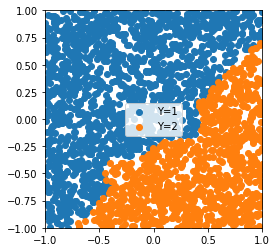

Beginning train loop.
Expecting a total of approximately 2500 examples and 625 batches per epoch from 1 payload(s) in the train split.
Writing config to /Users/vincentchen/code/metal/logs/2019_04_25/22_37_43/config.json


[1.0 epo]: test_task:[payload_train/labelset_gold/loss=2.86e-01, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=2.86e-01, train/all/lr=1.00e-02]



[2.0 epo]: test_task:[payload_train/labelset_gold/loss=1.14e-01, payload_valid/labelset_gold/accuracy=9.66e-01] model:[train/all/loss=1.14e-01, train/all/lr=1.00e-02]



[3.0 epo]: test_task:[payload_train/labelset_gold/loss=9.65e-02, payload_valid/labelset_gold/accuracy=9.67e-01] model:[train/all/loss=9.65e-02, train/all/lr=1.00e-02]



[4.0 epo]: test_task:[payload_train/labelset_gold/loss=9.19e-02, payload_valid/labelset_gold/accuracy=9.69e-01] model:[train/all/loss=9.19e-02, train/all/lr=1.00e-02]



[5.0 epo]: test_task:[payload_train/labelset_gold/loss=9.02e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=9.02e-02, train/all/lr=1.00e-02]



[6.0 epo]: test_task:[payload_train/labelset_gold/loss=8.97e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.97e-02, train/all/lr=1.00e-02]



[7.0 epo]: test_task:[payload_train/labelset_gold/loss=8.91e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.91e-02, train/all/lr=1.00e-02]



[8.0 epo]: test_task:[payload_train/labelset_gold/loss=8.81e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.81e-02, train/all/lr=1.00e-02]



[9.0 epo]: test_task:[payload_train/labelset_gold/loss=8.66e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.66e-02, train/all/lr=1.00e-02]



[10.0 epo]: test_task:[payload_train/labelset_gold/loss=8.47e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.47e-02, train/all/lr=1.00e-02]



[11.0 epo]: test_task:[payload_train/labelset_gold/loss=8.41e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.41e-02, train/all/lr=1.00e-02]



[12.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[13.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[14.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[15.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[16.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[17.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[18.0 epo]: test_task:[payload_train/labelset_gold/loss=8.40e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.40e-02, train/all/lr=1.00e-02]



[19.0 epo]: test_task:[payload_train/labelset_gold/loss=8.40e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.40e-02, train/all/lr=1.00e-02]



[20.0 epo]: test_task:[payload_train/labelset_gold/loss=8.40e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.40e-02, train/all/lr=1.00e-02]



[21.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[22.0 epo]: test_task:[payload_train/labelset_gold/loss=8.40e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.40e-02, train/all/lr=1.00e-02]



[23.0 epo]: test_task:[payload_train/labelset_gold/loss=8.40e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.40e-02, train/all/lr=1.00e-02]



[24.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[25.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[26.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[27.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[28.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[29.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[30.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[31.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[32.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[33.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[34.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[35.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[36.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[37.0 epo]: test_task:[payload_train/labelset_gold/loss=8.41e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.41e-02, train/all/lr=1.00e-02]



[38.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[39.0 epo]: test_task:[payload_train/labelset_gold/loss=8.41e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.41e-02, train/all/lr=1.00e-02]



[40.0 epo]: test_task:[payload_train/labelset_gold/loss=8.37e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.37e-02, train/all/lr=1.00e-02]



[41.0 epo]: test_task:[payload_train/labelset_gold/loss=8.40e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.40e-02, train/all/lr=1.00e-02]



[42.0 epo]: test_task:[payload_train/labelset_gold/loss=8.37e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.37e-02, train/all/lr=1.00e-02]



[43.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[44.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[45.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[46.0 epo]: test_task:[payload_train/labelset_gold/loss=8.37e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.37e-02, train/all/lr=1.00e-02]



[47.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[48.0 epo]: test_task:[payload_train/labelset_gold/loss=8.37e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.37e-02, train/all/lr=1.00e-02]



[49.0 epo]: test_task:[payload_train/labelset_gold/loss=8.39e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.39e-02, train/all/lr=1.00e-02]



[50.0 epo]: test_task:[payload_train/labelset_gold/loss=8.37e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.37e-02, train/all/lr=1.00e-02]



[51.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[52.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[53.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[54.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[55.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[56.0 epo]: test_task:[payload_train/labelset_gold/loss=8.38e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.38e-02, train/all/lr=1.00e-02]



[57.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[58.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[59.0 epo]: test_task:[payload_train/labelset_gold/loss=8.37e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.37e-02, train/all/lr=1.00e-02]



[60.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[61.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[62.0 epo]: test_task:[payload_train/labelset_gold/loss=8.37e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.37e-02, train/all/lr=1.00e-02]



[63.0 epo]: test_task:[payload_train/labelset_gold/loss=8.35e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.35e-02, train/all/lr=1.00e-02]



[64.0 epo]: test_task:[payload_train/labelset_gold/loss=8.37e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.37e-02, train/all/lr=1.00e-02]



[65.0 epo]: test_task:[payload_train/labelset_gold/loss=8.35e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.35e-02, train/all/lr=1.00e-02]



[66.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[67.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02]



[68.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[69.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02]



[70.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02]



[71.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[72.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02]



[73.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02]



[74.0 epo]: test_task:[payload_train/labelset_gold/loss=8.36e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.36e-02, train/all/lr=1.00e-02]



[75.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02]



[76.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[77.0 epo]: test_task:[payload_train/labelset_gold/loss=8.35e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.35e-02, train/all/lr=1.00e-02]



[78.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[79.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[80.0 epo]: test_task:[payload_train/labelset_gold/loss=8.35e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.35e-02, train/all/lr=1.00e-02]



[81.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[82.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[83.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02]



[84.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[85.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[86.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[87.0 epo]: test_task:[payload_train/labelset_gold/loss=8.34e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.34e-02, train/all/lr=1.00e-02]



[88.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[89.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.71e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[90.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[91.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.70e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[92.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[93.0 epo]: test_task:[payload_train/labelset_gold/loss=8.33e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.33e-02, train/all/lr=1.00e-02]



[94.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[95.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[96.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[97.0 epo]: test_task:[payload_train/labelset_gold/loss=8.32e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.32e-02, train/all/lr=1.00e-02]



[98.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.31e-02, train/all/lr=1.00e-02]



[99.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.31e-02, train/all/lr=1.00e-02]



[100.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.31e-02, train/all/lr=1.00e-02]



[101.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.31e-02, train/all/lr=1.00e-02]



[102.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.31e-02, train/all/lr=1.00e-02]



[103.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.31e-02, train/all/lr=1.00e-02]



[104.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.31e-02, train/all/lr=1.00e-02]



[105.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.31e-02, train/all/lr=1.00e-02]



[106.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[107.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[108.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[109.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[110.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[111.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[112.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[113.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[114.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[115.0 epo]: test_task:[payload_train/labelset_gold/loss=8.30e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.30e-02, train/all/lr=1.00e-02]



[116.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[117.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[118.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[119.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[120.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[121.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[122.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[123.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[124.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[125.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[126.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[127.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[128.0 epo]: test_task:[payload_train/labelset_gold/loss=8.29e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.29e-02, train/all/lr=1.00e-02]



[129.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[130.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[131.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[132.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[133.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[134.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[135.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[136.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[137.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[138.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[139.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[140.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[141.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[142.0 epo]: test_task:[payload_train/labelset_gold/loss=8.28e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.28e-02, train/all/lr=1.00e-02]



[143.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[144.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[145.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[146.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[147.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[148.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[149.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[150.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[151.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[152.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[153.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[154.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[155.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[156.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[157.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[158.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[159.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[160.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[161.0 epo]: test_task:[payload_train/labelset_gold/loss=8.27e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.27e-02, train/all/lr=1.00e-02]



[162.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[163.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[164.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[165.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[166.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[167.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[168.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[169.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[170.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[171.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[172.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[173.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[174.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[175.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[176.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[177.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[178.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[179.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[180.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[181.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[182.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[183.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[184.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[185.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[186.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[187.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[188.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[189.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[190.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[191.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[192.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[193.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[194.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[195.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[196.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[197.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[198.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[199.0 epo]: test_task:[payload_train/labelset_gold/loss=8.26e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.26e-02, train/all/lr=1.00e-02]



[200.0 epo]: test_task:[payload_train/labelset_gold/loss=8.25e-02, payload_valid/labelset_gold/accuracy=9.72e-01] model:[train/all/loss=8.25e-02, train/all/lr=1.00e-02]

Finished training
{'test_task/payload_test/labelset_gold/accuracy': 0.9664,
 'test_task/payload_train/labelset_gold/accuracy': 0.9684,
 'test_task/payload_valid/labelset_gold/accuracy': 0.972}
Cleaning checkpoints
Writing metrics to /Users/vincentchen/code/metal/logs/2019_04_25/22_37_43/metrics.json
Writing log to /Users/vincentchen/code/metal/logs/2019_04_25/22_37_43/log.json
Full model saved at /Users/vincentchen/code/metal/logs/2019_04_25/22_37_43/model.pkl
{'test_task/payload_train/labelset_gold/accuracy': 0.9684, 'test_task/payload_valid/labelset_gold/accuracy': 0.972, 'test_task/payload_test/labelset_gold/accuracy': 0.9664}
CPU times: user 37min 54s, sys: 1min 59s, total: 39min 54s
Wall time: 43min 34s


In [11]:
%%time
trained_models = {}
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    tasks = create_tasks(task_name, slice_names=list(slice_funcs.keys()), verbose=True)
    payloads = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=4, slice_funcs=slice_funcs, verbose=True)
    visualize_payload(payloads[0])
    model = model_class(tasks, verbose=False, seed=seed)
    trainer = MultitaskTrainer(seed=seed)
    metrics_dict = trainer.train_model(
        model, payloads, 
        lr=0.01, n_epochs=200, 
#         checkpoint_best=True,
#         checkpoint_metric="test_task/payload_valid/labelset_gold/accuracy",
#         checkpoint_metric_mode="max",
        writer="tensorboard", verbose=True, progress_bar=True
    )
    print(metrics_dict)
          
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'None' (originally, test_task).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:slice_1:ind': 'test_task:slice_1:ind',
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': 'test_task:slice_2:ind',
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.996,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9411764705882353,
    'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9744,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.8125}
Vizualizing test_task:slice_1:ind predictions on labelset:slice_1:ind


/Users/vincentchen/miniconda3/envs/mmtl/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


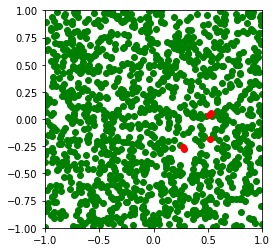

Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


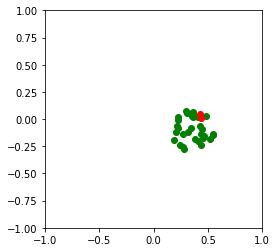

Vizualizing test_task:slice_2:ind predictions on labelset:slice_2:ind


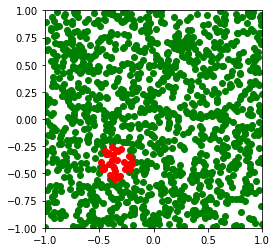

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


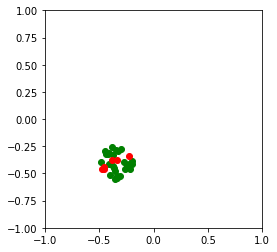

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:slice_1:ind': 'test_task:slice_1:ind',
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': 'test_task:slice_2:ind',
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:ind/payload_test/labelset:slice_1:ind/accuracy': 0.9728,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task:slice_2:ind/payload_test/labelset:slice_2:ind/accuracy': 0.9744,
    'test_task:slice_2:pred/payload_test/labelset:slice_2:pred/accuracy': 0.875}
Vizualizing test_task:slice_1:ind predictions on labelset:slice_1:ind


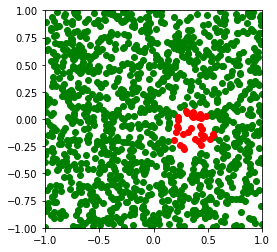

Vizualizing test_task:slice_1:pred predictions on labelset:slice_1:pred


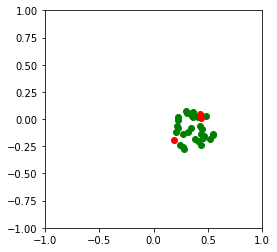

Vizualizing test_task:slice_2:ind predictions on labelset:slice_2:ind


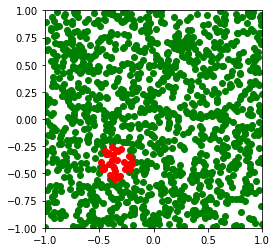

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


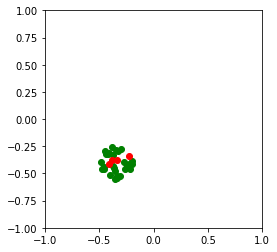

In [12]:
remap_labelsets(eval_payload, 
    labels_to_tasks= {
        "labelset:slice_1:ind": "test_task:slice_1:ind",
        "labelset:slice_1:pred": "test_task:slice_1:pred",
        "labelset:slice_2:ind": "test_task:slice_2:ind",
        "labelset:slice_2:pred": "test_task:slice_2:pred",        
    }
)


for model_name in model_configs.keys():
    if model_name in ["hard_param", "soft_param"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, None).
labelset 'labelset:slice_1:ind' -> task 'None' (originally, test_task:slice_1:ind).
labelset 'labelset:slice_1:pred' -> task 'test_task' (originally, test_task:slice_1:pred).
labelset 'labelset:slice_2:ind' -> task 'None' (originally, test_task:slice_2:ind).
labelset 'labelset:slice_2:pred' -> task 'test_task' (originally, test_task:slice_2:pred).
==========Evaluating soft_param==========
Eval mapping...
{   'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.9117647058823529,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.78125,
    'test_task/payload_test/labelset_gold/accuracy': 0.9792}
Vizualizing test_task predictions on labelset_gold


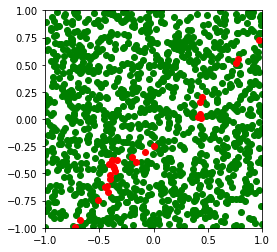

Vizualizing test_task predictions on labelset:slice_1:pred


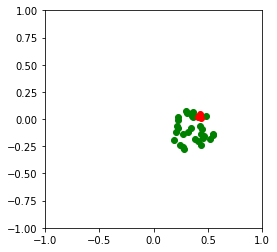

Vizualizing test_task predictions on labelset:slice_2:pred


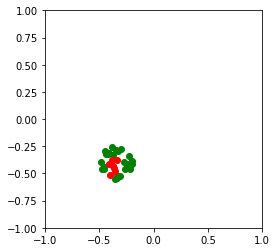

==========Evaluating hard_param==========
Eval mapping...
{   'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.7058823529411765,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.59375,
    'test_task/payload_test/labelset_gold/accuracy': 0.9624}
Vizualizing test_task predictions on labelset_gold


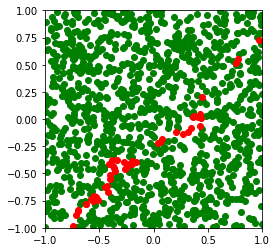

Vizualizing test_task predictions on labelset:slice_1:pred


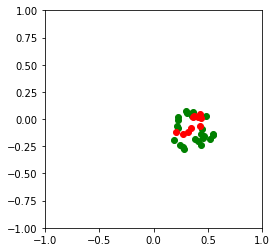

Vizualizing test_task predictions on labelset:slice_2:pred


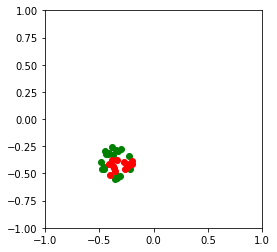

==========Evaluating naive==========
Eval mapping...
{   'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:slice_1:pred/accuracy': 0.5,
    'test_task/payload_test/labelset:slice_2:pred/accuracy': 0.5625,
    'test_task/payload_test/labelset_gold/accuracy': 0.9664}
Vizualizing test_task predictions on labelset_gold


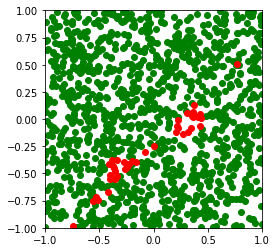

Vizualizing test_task predictions on labelset:slice_1:pred


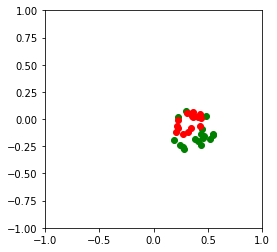

Vizualizing test_task predictions on labelset:slice_2:pred


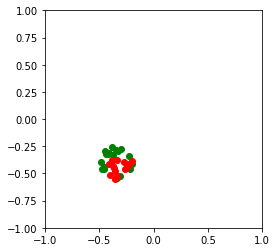

In [13]:
# map all labelsets to the primary task_head 
remap_labelsets(eval_payload, 
    labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:slice_1:pred": "test_task",
        "labelset:slice_2:pred": "test_task"
    }
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:ind' -> task 'test_task:slice_1:ind' (originally, None).
labelset 'labelset:slice_1:pred' -> task 'None' (originally, test_task).
labelset 'labelset:slice_2:ind' -> task 'test_task:slice_2:ind' (originally, None).
labelset 'labelset:slice_2:pred' -> task 'None' (originally, test_task).
Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


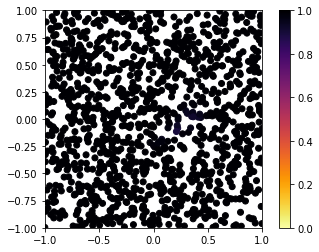

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


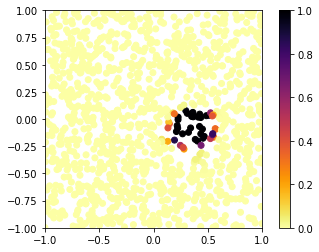

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


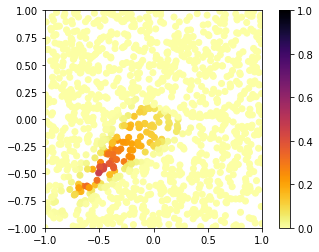

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


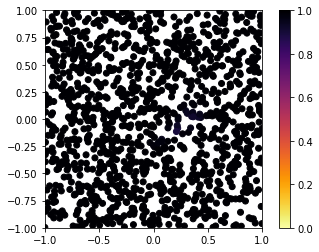

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


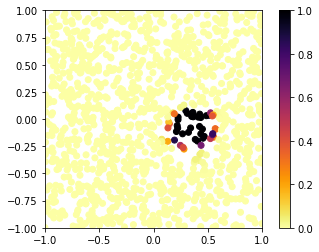

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


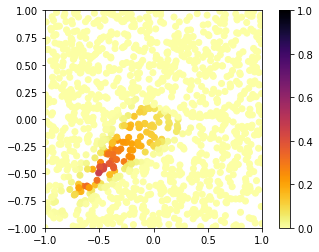

In [14]:
remap_labelsets( 
    eval_payload,
    labels_to_tasks = {
        "labelset:slice_1:ind": "test_task:slice_1:ind",
        "labelset:slice_2:ind": "test_task:slice_2:ind"
    }
)

visualize_attention(trained_models['soft_param'], eval_payload)